# Sentiment Analysis von Tweets

Das Projekt wurde im Rahmen der Veranstaltung zur maschinellen Sprachverarbeitung (Natural Language Processing, NLP) im WS 2021/22 an der Universität Tübingen von mir erfolgreich abgeschlossen. Die Hauptaufgabe des Projekts bestand darin, einen Klassifikator zu entwickeln, der entscheiden kann, ob eine Tweet positiv, negativ oder neutral ist. Als Daten für die von mir trainierten Klassifikatoren (Maximum Entropy Klassifikator, Support Vector Klassifikator und Decision Tree Klassifikator) dienten die Daten des SemEval 2013 Task 2b, ein Korpus mit 14882 annotierten Tweets. Informationen zum Korpus: https://aclanthology.org/S13-2052/. 


### Die im Projekt verwendeten Methoden und Bibliotheken

In [ ]:
# Einlesen und Visualisierung von Daten
import pandas as pd                          # Bibliothek zum Einlesen und Bearbeiten von Daten
import matplotlib.pyplot as plt              # Bibliothek zur Visualisierung von Daten
import seaborn as sns                        # Bibliothek zur Visualisierung von Daten

# Normalisierung von Daten
import re                                    # Modul zum Matchen von regulären Ausdrücken
import nltk                                  # Bibliothek für Anwendungen der Computerlinguistik
from nltk.tokenize import word_tokenize      # Methode zur Tokenisierung von Texten
from nltk.corpus import stopwords            # Liste von englischen Stoppwörtern
from nltk import FreqDist                    # Klasse zur Berechnung der Häufigkeiten von Wörtern
from nltk.stem import PorterStemmer          # Klasse zum Stemming von Wörtern
stop_words = stopwords.words('english')
ps = PorterStemmer()

# Klassifizierung
from nltk import NaiveBayesClassifier                   # Naive Bayes Klassifikator
from nltk.classify import DecisionTreeClassifier        # Decision Tree Klassifikator
from nltk.classify import MaxentClassifier              # Maximum Entropy Klassifikator
from nltk.classify.scikitlearn import SklearnClassifier # Sklearn Klassifikator (ermöglicht innerhalb von NLTK unterschiedliche Klassifikatoren zu nutzen)
from sklearn.svm import SVC                             # Support Vector Klassifikator

### A1: Daten einlesen

In [157]:
# Drei Datensätze einlesen: Trainingsdaten (train_data), Entwicklungsdaten (dev_data) und Testdaten (test_data)
train_data = pd.read_csv("semeval2013/twitter-2013train-A.txt", sep = '\t', header = None)
test_data = pd.read_csv("semeval2013/twitter-2013test-A.txt", sep = '\t', header = None)
dev_data = pd.read_csv("semeval2013/twitter-2013dev-A.txt", sep = '\t', header = None)

# Spalten von jedem der drei Datensätze benennen: id, sentiment (Stimmungswert: positiv, neutral negativ), tweet
train_data.columns = ['id', 'sentiment', 'tweet']
test_data.columns = ['id', 'sentiment', 'tweet']
dev_data.columns = ['id', 'sentiment', 'tweet']

# Trainingsdaten enthalten 9683 Tweets = 65% vom ganzen Datensatz
train_data.tail()

,id,sentiment,tweet
9679,103158179306807296,positive,RT @MNFootNg It's monday and Monday Night Foot...
9680,103157324096618497,positive,All I know is the road for that Lomardi start ...
9681,100259220338905089,neutral,"All Blue and White fam, we r meeting at Golden..."
9682,104230318525001729,positive,@DariusButler28 Have a great game agaist Tam...
9683,100461938533863424,negative,I'm pisseeedddd that I missed Kid Cudi's show ...


In [158]:
# Testdaten enthalten 3546 Tweets = 24 % vom ganzen Datensatz
test_data.tail()

,id,sentiment,tweet
3542,264233437060288512,negative,Khaleda Zia's present India visit may have a b...
3543,263779058284904448,neutral,"FYI, golf fans: @jameslepp will join Moj on We..."
3544,250744453831213056,negative,@__Aniko you think mr.Calle let practice with ...
3545,258679974591090688,positive,Don't hide under your desk! It's just a salsa ...
3546,243018372453916674,neutral,Saturday flashmob on the music of The Runaways...


In [159]:
# Entwicklungsdaten enthalten 1653 Tweets = 11 % vom ganzen Datensatz
dev_data.tail()

,id,sentiment,tweet
1649,264241571908681728,neutral,#WEB YouTube improves upload process with opti...
1650,264228980444495875,positive,Gonna change my Tumblr theme. I hope I can fin...
1651,264210367192915968,neutral,I\u2019m so jealous of everyone at the Justin ...
1652,263737249240342528,neutral,Jim Harbaugh\u002c Alex Smith Drive Giants Wor...
1653,264096818831433728,neutral,#Trending: Tim Tebow is now dating cave woman ...


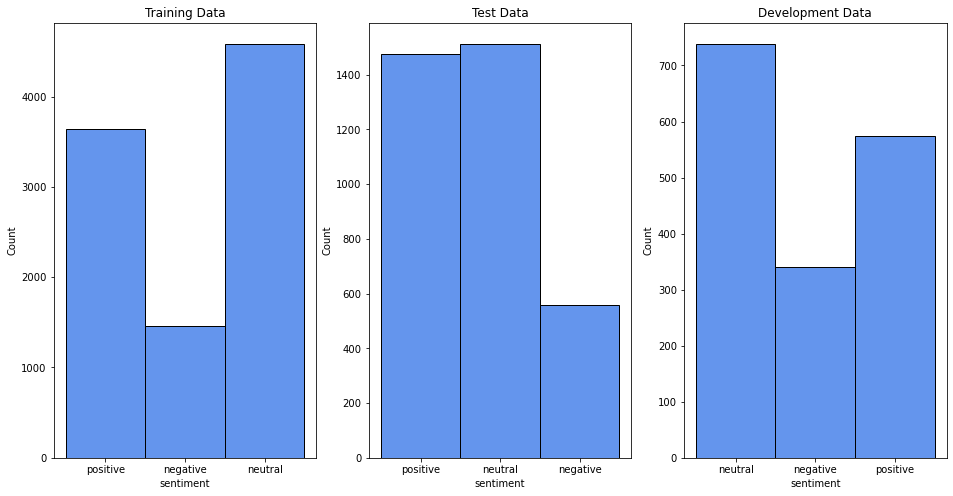

In [160]:
# die Distribution der Stimmungswerte der Trainigsdaten visualisieren
fig, axs = plt.subplots(1, 3, figsize=(16, 8))
axs[0].set_title('Training Data')
axs[1].set_title('Test Data')
axs[2].set_title('Development Data')
order_list = ['neutral', 'positive', 'negative']
sns.histplot(train_data['sentiment'], color='cornflowerblue', alpha=1, ax=axs[0])
sns.histplot(test_data['sentiment'], color='cornflowerblue', alpha=1, ax=axs[1])
sns.histplot(dev_data['sentiment'], color='cornflowerblue', alpha=1, ax=axs[2])
plt.show()
# Man sieht, dass die Stimmungswerte in allen drei Datensätzen unterschiedliche Distributionen haben,
# d.h. die Daten sind nicht balanciert:
# Es gibt wenige negative Stimmungswerte und viele neutrale.

### A2: Eine Baseline implementieren
#### A2. Schritt 1: Textdaten (Tweets) normalisieren

In [161]:
def normalize_data(tweet):
    
    normalized_tweet = tweet.lower()
    normalized_tweet = re.sub(r'https?:\/\/\S+', '', normalized_tweet)
    normalized_tweet = re.sub(r'@[A-Za-z0-9]+', '', normalized_tweet)
    normalized_tweet = re.sub(r'#', '', normalized_tweet)
    normalized_tweet = re.sub(r'\\u[a-z|0-9]{4}', '', normalized_tweet)
    normalized_tweet = [token for token in word_tokenize(normalized_tweet) if token.isalpha() and not token in stop_words and len(token)>=3]
     
    return normalized_tweet

In [162]:
# Die Normalisierungsfunktion auf Rohdaten (Tweets) anwenden
train_data['normalized_tweet'] = train_data['tweet'].apply(normalize_data)
test_data['normalized_tweet'] = test_data['tweet'].apply(normalize_data)
dev_data['normalized_tweet'] = dev_data['tweet'].apply(normalize_data)

In [163]:
# Drei Datensätze mit den normalisierten Tweets und den entsprechenden Stimmungswerten erstellen.
# Diese werden später für Klassifiezierungsmodelle benötigt.
tweets_train = list(zip(train_data['normalized_tweet'], train_data['sentiment']))    
tweets_test = list(zip(test_data['normalized_tweet'], test_data['sentiment']))
tweets_dev = list(zip(dev_data['normalized_tweet'], dev_data['sentiment']))

#### A2. Schritt 2: Tokens aus den normalisierten Tweets extrahieren

In [164]:
def get_all_words_from_tweets(tweets):
    
    all_words = []
    for tweet in tweets:
        for word in tweet:
            all_words.append(word)
    
    return all_words

all_words_train = get_all_words_from_tweets(train_data['normalized_tweet'])
all_words_test = get_all_words_from_tweets(test_data['normalized_tweet'])
all_words_dev = get_all_words_from_tweets(dev_data['normalized_tweet'])
all_words = all_words_train + all_words_test + all_words_dev

print(len(all_words))
print(all_words[:10])

153237
['gas', 'house', 'hit', 'going', 'chapel', 'hill', 'sat', 'theo', 'walcott', 'still']


#### A2. Schritt 3: Features (die 1000 häufigsten Tokens) extrahieren

In [165]:
def get_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    most_common_features = wordlist.most_common(1000)
    return [word for (word, freq) in most_common_features]

word_features = get_features(all_words)
print(word_features[:10])

['tomorrow', 'may', 'day', 'night', 'going', 'see', 'saturday', 'sunday', 'game', 'time']


#### A2. Schritt 4: Das Vorhandensein von Features in den normalisierten Tweets feststellen

In [166]:
def extract_features(tweet):
    features = {}
    for word in word_features:
        features[f'contains {word}'] = (word in set(tweet))
    return features

In [167]:
# Das Vorhandensein von Features in den normalisierten Tweets feststellen
labeled_features_train = [(extract_features(tweet), sentiment) for (tweet, sentiment) in tweets_train]
labeled_features_test = [(extract_features(tweet), sentiment) for (tweet, sentiment) in tweets_test]
labeled_features_dev = [(extract_features(tweet), sentiment) for (tweet, sentiment) in tweets_dev]

#### A2. Schritt 5: Naive Bayes Classifier trainieren

In [168]:
nb_classifier = NaiveBayesClassifier.train(labeled_features_train)

### A3: Evaluierung durchführen

In [169]:
accuracy = nltk.classify.accuracy(nb_classifier, labeled_features_test)
print("Accuracy of Naive Bayes Classifier: ",accuracy)
nb_classifier.show_most_informative_features(10)

Accuracy of Naive Bayes Classifier:  0.639413588948407
Most Informative Features
           contains fuck = True           negati : neutra =     91.2 : 1.0
        contains amazing = True           positi : neutra =     49.1 : 1.0
        contains excited = True           positi : neutra =     43.0 : 1.0
           contains luck = True           positi : neutra =     39.9 : 1.0
          contains thank = True           positi : neutra =     34.0 : 1.0
          contains sorry = True           negati : neutra =     29.6 : 1.0
          contains happy = True           positi : neutra =     29.5 : 1.0
         contains injury = True           negati : positi =     27.5 : 1.0
        contains awesome = True           positi : neutra =     27.0 : 1.0
          contains great = True           positi : neutra =     23.5 : 1.0


### A4 und A5: Ein weiteres Verfahren implementieren und solche Features wie Stamm/Lemma und POS-Tag ehtrahieren
#### A4 und A5. Schritt 1: Normalisierung der Daten

In [170]:
# Rohdaten (Tweets) normalisieren. Diesmal werden die Tokens lemmatisiert.
# Darüber hinaus wird jedem der Tokens ein POS-Tag zugeschrieben

def normalize_data_2(tweet):
    
    # normalized_tweet = tweet.lower()
    normalized_tweet = re.sub(r'https?:\/\/\S+', '', tweet)
    normalized_tweet = re.sub(r'@[A-Za-z0-9]+', '', normalized_tweet)
    normalized_tweet = re.sub(r'#', '', normalized_tweet)
    normalized_tweet = re.sub(r'\\u[a-z|0-9]{4}', '', normalized_tweet)
    normalized_tweet = [token for token in word_tokenize(normalized_tweet) if token.isalpha() and not token in stop_words and len(token)>=3]
    normalized_tweet = nltk.pos_tag(normalized_tweet)
    normalized_tweet = [(ps.stem(word).lower(), tag) for word, tag in normalized_tweet]
    
    return normalized_tweet

In [171]:
# Funktion zum Entfernen der POS-Tags. Diese wird später für die Anpassung von Trainings- und Testdaten benötigt.
def remove_tags(normalized_tweet):
    new_tweet = [word for (word, tag) in normalized_tweet]
    return new_tweet

In [172]:
# Die neue Normalisierungsfunktion auf Rohdaten (Tweets) anwenden
train_data['normalized_tweet_2'] = train_data['tweet'].apply(normalize_data_2)
test_data['normalized_tweet_2'] = test_data['tweet'].apply(normalize_data_2)
dev_data['normalized_tweet_2'] = dev_data['tweet'].apply(normalize_data_2)

train_data['normalized_tweet_2'][:5]

0    [(ga, NNP), (hous, NN), (hit, VBD), (go, VBG),...
1    [(theo, NNP), (walcott, NNP), (still, RB), (sh...
2    [(gsp, NNP), (fan, NN), (hate, NN), (nick, NNP...
3    [(iranian, JJ), (gener, JJ), (say, VBZ), (isra...
4    [(tehran, NNP), (mon, NNP), (amour, NNP), (oba...
Name: normalized_tweet_2, dtype: object

In [173]:
# Entfernen der POS-Tags, da diese bei der späteren Evaluierung nicht mehr benötigt werden.
tweets_train_2 = list(zip(train_data['normalized_tweet_2'].apply(remove_tags), train_data['sentiment']))    
tweets_test_2 = list(zip(test_data['normalized_tweet_2'].apply(remove_tags), test_data['sentiment']))
tweets_dev_2 = list(zip(dev_data['normalized_tweet_2'].apply(remove_tags), dev_data['sentiment']))

for i, data in enumerate(tweets_train_2[:10]):
    print(f'{i} {data}')

0 (['ga', 'hous', 'hit', 'go', 'chapel', 'hill', 'sat'], 'positive')
1 (['theo', 'walcott', 'still', 'shit', 'watch', 'rafa', 'johnni', 'deal', 'saturday'], 'negative')
2 (['gsp', 'fan', 'hate', 'nick', 'diaz', 'cant', 'wait', 'februari'], 'negative')
3 (['iranian', 'gener', 'say', 'israel', 'iron', 'dome', 'cant', 'deal', 'missil', 'keep', 'talk', 'like', 'may', 'end', 'find'], 'negative')
4 (['tehran', 'mon', 'amour', 'obama', 'tri', 'establish', 'tie', 'mullah', 'via', 'barack', 'obama', 'vote', 'mitt', 'romney'], 'neutral')
5 (['sat', 'whole', 'movi', 'harri', 'ron', 'christma', 'ohlawd'], 'neutral')
6 (['davlar', 'main', 'rival', 'team', 'poland', 'hope', 'make', 'success', 'end', 'tough', 'week', 'train', 'tomorrow'], 'positive')
7 (['talk', 'act', 'sat', 'decid', 'want', 'colleg', 'appli', 'colleg', 'everyth', 'colleg', 'stress'], 'negative')
8 (['whi', 'happi', 'valentin', 'trend', 'it', 'februari', 'june', 'smh'], 'neutral')
9 (['they', 'may', 'superbowl', 'dalla', 'dalla', 'a

#### A4 und A5. Schritt 2: Adjektive und Adverbien aus den normalisierten Tweets extrahieren

In [174]:
def get_all_adjectives_and_adverbs_from_tweets(tweets):
    all_adjs_and_adverbs = []
    for tweet in tweets:
        for (word, tag) in tweet:
            if tag.startswith('JJ') or tag.startswith('RB'):
                all_adjs_and_adverbs.append(word)
    
    return all_adjs_and_adverbs

all_adjs_and_adverbs_train = get_all_adjectives_and_adverbs_from_tweets(train_data['normalized_tweet_2'])
all_adjs_and_adverbs_test = get_all_adjectives_and_adverbs_from_tweets(test_data['normalized_tweet_2'])
all_adjs_and_adverbs_dev = get_all_adjectives_and_adverbs_from_tweets(dev_data['normalized_tweet_2'])
all_adjs_and_adverbs = all_adjs_and_adverbs_train + all_adjs_and_adverbs_test + all_adjs_and_adverbs_dev
print(len(all_adjs_and_adverbs))
# print(nltk.FreqDist(all_adjs_and_adverbs).most_common(150))

19251


#### A4 und A5. Schritt 3: Die 1000 häufigsten Adjektive und Adverbien extrahieren

In [175]:
def get_features_2(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    most_common_features = wordlist.most_common(1000)
    return [word for (word, freq) in most_common_features]

word_features_2 = get_features_2(all_adjs_and_adverbs)

#### A4 und A5. Schritt 4. Das Vorhandensein von den Adjektiven in den Tweets feststellen

In [176]:
def extract_features_2(tweet):
    features = {}
    for word in word_features_2:
        features[f'contains {word}'] = (word in set(tweet))
    return features

In [177]:
# Das Vorhandensein von den Adjektiven in den Tweets feststellen
labeled_features_train_2 = [(extract_features_2(tweet), sentiment) for (tweet, sentiment) in tweets_train_2]
labeled_features_test_2 = [(extract_features_2(tweet), sentiment) for (tweet, sentiment) in tweets_test_2]
labeled_features_dev_2 = [(extract_features_2(tweet), sentiment) for (tweet, sentiment) in tweets_dev_2]

#### A4 und A5. Schritt 5: Naive Bayes Classifier trainieren

In [178]:
nb_classifier_2 = NaiveBayesClassifier.train(labeled_features_train_2)

### A6: Evaluierung durchführen

In [179]:
accuracy_2 = nltk.classify.accuracy(nb_classifier_2, labeled_features_test_2)
print("Accuracy of Naive Bayes Classifier: ",accuracy_2)
nb_classifier_2.show_most_informative_features(10)

Accuracy of Naive Bayes Classifier:  0.6543557936284183
Most Informative Features
          contains excit = True           positi : neutra =     39.6 : 1.0
           contains fuck = True           negati : neutra =     36.9 : 1.0
          contains happi = True           positi : neutra =     29.8 : 1.0
          contains sorri = True           negati : neutra =     29.6 : 1.0
           contains amaz = True           positi : neutra =     29.5 : 1.0
         contains awesom = True           positi : neutra =     27.0 : 1.0
          contains thank = True           positi : neutra =     25.1 : 1.0
            contains sad = True           negati : neutra =     23.8 : 1.0
           contains fail = True           negati : positi =     22.5 : 1.0
          contains great = True           positi : neutra =     21.2 : 1.0


In [180]:
# Maximum Entropy Klassifikator trainiren und evaluieren
maxent_classifier = MaxentClassifier.train(labeled_features_train_2, max_iter=5)
nltk.classify.accuracy(maxent_classifier, labeled_features_test_2)

  ==> Training (5 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -1.09861        0.376
             2          -1.06387        0.404
             3          -1.03565        0.404
             4          -1.01413        0.404
         Final          -0.99847        0.404


0.4299407950380603

In [181]:
# Support Vector Klassifikator trainieren und evaluieren
SVC_classifier = SklearnClassifier(SVC())
SVC_classifier.train(labeled_features_train_2)
nltk.classify.accuracy(SVC_classifier, labeled_features_test_2)

0.6478714406540739

In [154]:
# Decision Tree Klassifikator trainieren und evaluieren
decisiont_classifier = DecisionTreeClassifier.train(labeled_features_train_2)
nltk.classify.accuracy(decisiont_classifier,  labeled_features_test_2)

0.6433605864110515

### A7: Zusammenfassung der Ergebnisse

Im Rahmen des Projektes wurden folgende Klassifikationsmodelle trainiert: Naive Bayes, Maximum Entropy, Decision Tree sowie Support Vector Klassifikatoren. Die genannten Modelle analysieren die normalisierten Tweets, indem sie aufgrund von den definierten Features jeden der Tweets als neutral, positiv oder negativ einstufen. Die Accuracy-Werte der Modelle sehen wie folgt aus:

- Die 1000 häufigsten Tokens aus den normalisierten Tweets als Features
   - Der Accuracy-Wert von Naive Bayes Klassifikator: 0,639


- Die 1000 häufigsten Adjektive und Adverbien aus den normalisierten Tweets als Features
   - Der Accuracy-Wert von Naive Bayes Klassifikator: 0,654

Man sieht, dass die 1000 häufigsten Adjektive und Adverbien als etwas bessere Features für das Modell erscheinen, da diese den Accuracy-Wert von Naive Bayes leicht erhöhen. Dies kann dafür sprechen, dass Adjektive und Adverbien mehr Informationsgehalt bezüglich der Stimmungswerte positiv, negativ und neutral beinhalten. Der Accuracy-Wert könnte wahrscheinlich noch erhöht werden, indem man einen besseren POS-Tagger implementiert sowie die Rechtsschreibkorrektur durchführt. Außerdem stellt sich noch die Frage, ob der Accuracy-Wert aufgrund von dem nicht balancierten Datensatz ein zuverlässiges Ergebnis ist und ob die Balancierung von Daten in Bezug auf die Stimmungswerte neutral, positiv und negativ nötig ist. 

Für das Trainieren der drei anderen Klassifikationsmodelle - Maximum Entropy, Support Vector und Decision Tree - wurden die 1000 häufigsten Adjektive und Adverbien als Features eingesetzt, da diese den Naive Bayes Klassifikator zu besseren Ergebnissen geführt haben. Die Accuracy-Werte der Modelle sehen jedoch etwas schlechter als die des Naive Bayes Klassifikators aus:

- Die 1000 häufigsten Adjektive und Adverbien aus den normalisierten Tweets als Features
  - Der Accuracy-Wert von Maximum Entropy Klassifikator: 0,429
  - Der Accuracy-Wert von Support Vector Klassifikator: 0,647
  - Der Accuracy-Wert von Decision Tree Klassifikator: 0,643

Die schlechtesten Accuracy-Werte zeigt der Maximun Entropy Klassifikator. Die besseren Werte werden von den Klassifikatoren Support Vector und Decision Tree geliefert. Diese fallen jedoch etwas niedriger als die Werte von dem Naive Bayes Klassifikator aus. Trotz seiner naiven Grundannahme erzielt also der Naive Bayes Klassifikator die besten Ergebnisse im Rahmen des vorliegenden Projektes. 